In [1]:
%load_ext autoreload
%autoreload 2

In [137]:
from llib import *

import cv2
import numpy as np
from PIL import Image
import pandas as pd

# 1. Data Augmentation

Nesta etapa foi feita [COMPLETAR]

In [4]:
original_dataset = read_dataset(DATASET_DIR)
original_gray_dataset = apply_transformations_to_dataset(original_dataset, [rgb2gray])
augmented_dataset = apply_transformations_to_dataset(original_gray_dataset, [exp_transform, log_transform, mean_filter, gray_gradient])

/home/decarv/projects/image-classifier/src/llib.py:219: RuntimeWarning: divide by zero encountered in log
  log_transformed = c * np.log(1 + image)
/home/decarv/projects/image-classifier/src/llib.py:220: RuntimeWarning: invalid value encountered in cast
  log_transformed = np.array(log_transformed, dtype=np.uint8)


In [5]:
plot_mnist(original_dataset)

In [6]:
plot_mnist(original_gray_dataset)

In [7]:
plot_mnist(augmented_dataset)

In [8]:
for k in original_gray_dataset.keys():
    augmented_dataset[k].extend(original_gray_dataset[k])

#### Correção de Brilho

In [9]:
corrected_dataset = apply_transformations_to_dataset(augmented_dataset, [log_transform])
augmented_dataset = corrected_dataset

# 2. Normalizacao

Nesta etapa foi feita [COMPLETAR]

In [10]:
normalized_augmented_dataset = normalize_dataset(augmented_dataset)

In [11]:
dataset = []
for cls in normalized_augmented_dataset:
    for im in normalized_augmented_dataset[cls]:
        inst = {
            'class': cls,
            'image': im,
        }
        dataset.append(inst)
normalized_augmented_dataset = dataset

# 3. Segmentação

Nesta etapa foi realizada [COMPLETAR]

## 3.1. Segmentação Manual

## 3.2. Segmentação Automática

In [12]:
filter_diameters = [5, 9]
sigma_colors = [50, 75]
sigma_spaces = [50, 75]
kernel_sizes = [3, 5]
iterations = [1, 2]

In [18]:
from llib import *

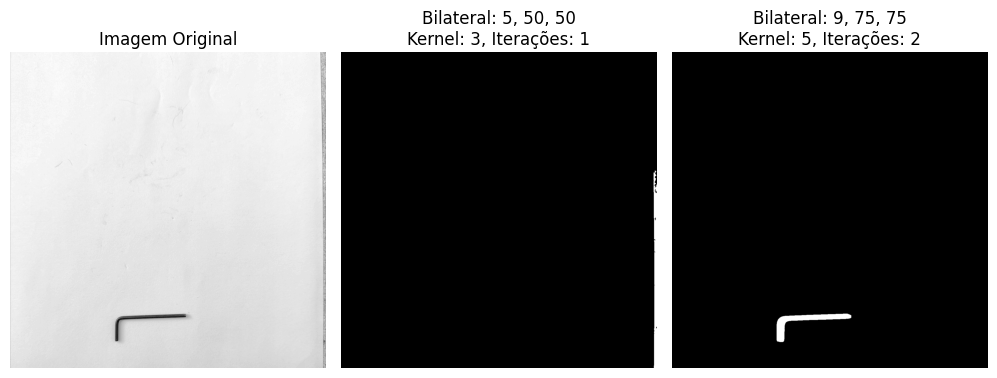

In [19]:
# Experimentos com diferentes configurações para segmentação.
# Nesta célula foram plotados alguns exemplos, mas os testes foram feitos usando várias configurações diferentes.

image = normalized_augmented_dataset[0]['image']

plt.figure(figsize=(20, 10))
plt.subplot(1, 6, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')

for i, (d, sc, ss, ks, it) in enumerate(zip(filter_diameters, sigma_colors, sigma_spaces, kernel_sizes, iterations), start=2):
    filled_mask = create_segmentation_mask(image, d, sc, ss, ks, it)
    
    # Plot the results
    plt.subplot(1, 6, i)
    plt.imshow(filled_mask, cmap='gray')
    plt.title(f'Bilateral: {d}, {sc}, {ss}\nKernel: {ks}, Iterações: {it}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
ground_truth_grid = create_ground_truth_grid(normalized_augmented_dataset, filter_diameters, sigma_colors, sigma_spaces, kernel_sizes, iterations)

In [21]:
segmented_datasets = []
for dataset in ground_truth_grid:
    segmented_datasets.append({'df': pd.DataFrame(dataset['dataset']), 'params': dataset['parameters']})

# 4. Extração da Ferret Box

Nesta etapa foi realizada [COMPLETAR]

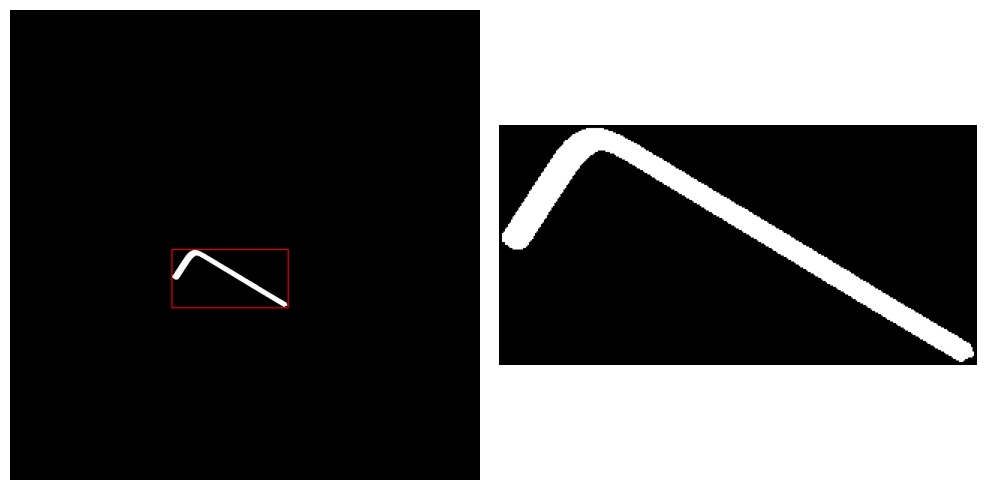

In [37]:
sample = segmented_datasets[0]['df'].iloc[4,0]

bounding_box_image, extracted_region = draw_bounding_box(sample)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(bounding_box_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(extracted_region, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Extração de Características

Nesta etapa foi realizada [COMPLETAR]

## Extração

In [40]:
features_dfs = []
for dataset in segmented_datasets:
    features_dfs.append({
        'df': create_feature_dataframe(dataset['df']),
        'params': dataset['params']
    })

## Limpeza

In [43]:
df = features_dfs[0]['df']

In [61]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    Q1 = df.iloc[:, :-1].quantile(0.25)
    Q3 = df.iloc[:, :-1].quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = (df.iloc[:, :-1] < (Q1 - 1.5 * IQR)) | (df.iloc[:, :-1] > (Q3 + 1.5 * IQR))
    return df[~outlier_mask.any(axis=1)]

In [62]:
for i, dataset in enumerate(features_dfs):
    features_dfs[i]['df'] = clean_dataframe(dataset['df'])

# Criação do Classificador

In [88]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


In [73]:
def eval_classifiers(dfs: list[dict[str, list | pd.DataFrame]]) -> list[dict]:
    scores = []
    for data in dfs:
        params = data['params']
        df = data['df']
        scores_dict = {'params': params, 'best': {}, 'classifiers': {}, 'scores': []}
        
        le = LabelEncoder()
        df['class'] = le.fit_transform(df['class'])
        
        X = df.drop('class', axis=1)
        y = df['class']
        
        selector = SelectKBest(score_func=mutual_info_classif, k='all')
        X_new = selector.fit_transform(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)
        
        classifiers = {
            'KNN': KNeighborsClassifier(),
            'SVM': SVC(),
            'RandomForest': RandomForestClassifier(),
            'DecisionTree': DecisionTreeClassifier(),
            'LogisticRegression': LogisticRegression()
        }
    
        best_name: str = ""
        best_accuracy: float = 0.0
        for name, clf in classifiers.items():
            scores_dict['classifiers'][name] = {}
            clf.fit(X_train, y_train)
            try:
                y_pred = clf.predict(X_test)
                scores_dict['classifiers'][name]['acc'] = accuracy_score(y_test, y_pred)
                scores_dict['classifiers'][name]['report'] = classification_report(y_test, y_pred)
            except ValueError:
                scores_dict['classifiers'][name]['acc'] = 0.0
                scores_dict['classifiers'][name]['report'] = 0.0

            if best_accuracy < scores_dict['classifiers'][name]['acc']:
                best_accuracy = scores_dict['classifiers'][name]['acc']
                best_name = name
    
        scores_dict['scores'] = selector.scores_
        scores_dict['best'] = {'name': best_name, 'acc': best_accuracy, 'params': params}
        scores.append(scores_dict)
    return scores

In [71]:
scores = eval_classifiers(features_dfs)

/tmp/ipykernel_136187/4257068185.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = le.fit_transform(df['class'])
/home/decarv/projects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/decarv/projects/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [69]:
for s in scores:
    print(s['best'])

{'name': 'DecisionTree', 'acc': 0.9032258064516129, 'params': (5, 50, 50, 3, 1)}
{'name': 'RandomForest', 'acc': 0.7878787878787878, 'params': (5, 50, 50, 3, 2)}
{'name': 'RandomForest', 'acc': 0.8181818181818182, 'params': (5, 50, 50, 5, 1)}
{'name': 'RandomForest', 'acc': 0.90625, 'params': (5, 50, 50, 5, 2)}
{'name': 'RandomForest', 'acc': 0.9032258064516129, 'params': (5, 50, 75, 3, 1)}
{'name': 'RandomForest', 'acc': 0.9090909090909091, 'params': (5, 50, 75, 3, 2)}
{'name': 'RandomForest', 'acc': 0.9090909090909091, 'params': (5, 50, 75, 5, 1)}
{'name': 'RandomForest', 'acc': 0.875, 'params': (5, 50, 75, 5, 2)}
{'name': 'RandomForest', 'acc': 0.9375, 'params': (5, 75, 50, 3, 1)}
{'name': 'DecisionTree', 'acc': 0.8484848484848485, 'params': (5, 75, 50, 3, 2)}
{'name': 'RandomForest', 'acc': 0.8484848484848485, 'params': (5, 75, 50, 5, 1)}
{'name': 'RandomForest', 'acc': 0.9375, 'params': (5, 75, 50, 5, 2)}
{'name': 'RandomForest', 'acc': 0.84375, 'params': (5, 75, 75, 3, 1)}
{'name

## Armazenando O Melhor Classificador

In [116]:
import pickle

In [138]:
def store_best_random_forest(dfs: list[dict[str, list | pd.DataFrame]], save_path) -> list[dict]:
    scores = []
    best_overall_classifier = None
    highest_accuracy = 0
    best_overall_params = None
    best_overall_importances = None

    for data in dfs:
        params = data['params']
        df = data['df']
        scores_dict = {'params': params, 'classifiers': {}}
        
        le = LabelEncoder()
        df['class'] = le.fit_transform(df['class'])
        
        X = df.drop('class', axis=1)
        y = df['class']

        forest = RandomForestClassifier(n_estimators=100)
        forest.fit(X, y)

        sfm = SelectFromModel(forest, threshold=0.01)
        X_transformed = sfm.fit_transform(X, y)

        X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3)

        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        feature_importances = forest.feature_importances_[sfm.get_support()]

        scores_dict['classifiers']['RandomForest'] = {
            'acc': accuracy,
            'report': report,
            'feature_importances': feature_importances
        }

        if accuracy > highest_accuracy:
            highest_accuracy = accuracy
            best_overall_classifier = forest
            best_overall_params = params
            best_overall_importances = feature_importances

        scores.append(scores_dict)

    if best_overall_classifier:
        with open(save_path, 'wb') as file:
            pickle.dump(best_overall_classifier, file)

    best_classifier_info = {
        'accuracy': highest_accuracy,
        'params': best_overall_params,
        'feature_importances': list(best_overall_importances)
    }

    return scores, best_classifier_info

In [139]:
from llib import *

In [140]:
scores, best_classifier_info = store_best_random_forest(features_dfs, CLASSIFIER_FILEPATH)
best_classifier_info

/home/decarv/projects/image-classifier/src/llib.py:506: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'accuracy': 0.96875,
 'params': (9, 75, 50, 3, 2),
 'feature_importances': [0.13180487207697525,
  0.09658023020780565,
  0.07575721861561192,
  0.0777006397394438,
  0.3083873156270749,
  0.11984415574037273,
  0.07405751933897585,
  0.08325166474671133,
  0.032616383907028645]}

In [130]:
with open("classifier.json", 'w') as f:
    f.write(json.dumps(best_classifier_info))

## Carregando o Classificador

In [135]:
with open(CLASSIFIER_FILEPATH, "rb") as f:
    cl = pickle.load(f)

In [136]:
cl

RandomForestClassifier()